In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move into project directory
repo_name = "UMass-CS670-Project"
%cd /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name
!ls

/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project
COD10K-v3.zip  data	  experiments	  github-repo-clone.ipynb  index.py  README.md
common	       datautils  get_dataset.sh  Index.ipynb		   models    SINet.ipynb


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# uncomment the lines below  to download the data

import os

!pip install gdown

data_dir="data"

if not(os.path.exists("./data")):
    !gdown https://drive.google.com/uc?id=18oBjWeuw5qAq4HG_jZdjUHas4APy-KJE&export=download
    os.mkdir("data")
    #echo 'Downloaded data! Unzipping to data folder'
    !unzip -qq -d ./$data_dir ./COD10K-v3.zip
    os.rename("./COD10K-v3.zip", "./data/COD10K-v3.zip")
else:
    print("\nThe data directory exists!")


The data directory exists!


In [5]:
# setup some imports
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset
from torch.utils.data import DataLoader
import random
import numpy as np
import torch
import argparse
from tqdm import tqdm

from experiments.style_transfer import style_transfer
from common.visualizer import layer_visualizer

In [6]:
import torch
from models.ots_models import get_model
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io
from torchvision.io import read_image
from common.utils import convert_to_grascale, get_transforms

def __get_gram_matrix(features):
    n,c,h,w = features.size()
    features = torch.reshape(features, (n, c, h*w))
    G = torch.matmul(features, features.transpose(1, 2))
    G /= (h * w * c)
    return G


def __content_loss(content_weight, curr_content, orig_content):
    return content_weight * torch.sum((curr_content - orig_content)**2)

def __style_loss(features, style_layers, style_grams, style_weights):

    if torch.cuda.is_available():
        stloss = torch.tensor(0.0).to('cuda')
    else:
        stloss = torch.tensor(0.0)

    for i in range(len(style_layers)):
        stlyr = features[style_layers[i]].clone()
        gm = __get_gram_matrix(stlyr)
        stloss += (style_weights[i] * torch.sum((style_grams[i] - gm)**2))

    return stloss

def __tv_loss(img, tv_weight):
    _, _, h, w = img.size()
    lt = torch.sum((img[:, :, 1:h, :] - img[:, :, :h-1, :])**2)
    rt = torch.sum((img[:, :, :, 1:w] - img[:, :, :, :w-1])**2)
    tvloss = tv_weight * (lt + rt)
    return tvloss

def __get_features(img, model_features):
    features = []
    x = img

    for _, layer in enumerate(model_features._modules.values()):
        op = layer(x)
        features.append(op)
        x = op

    return features


def style_transfer(content_img, style_layers, content_layer, content_weight, style_weights, tv_weight, args):

    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        device = 'cuda'
    else:
        dtype = torch.FloatTensor
        device = 'cpu'

    model, _ = get_model(args.model_name, True)
    model_features = model.features
    model_features.type(dtype)

    for param in model_features.parameters():
        param.requires_grad = False

    style_img = read_image('./data/Textures/tree-bark.jpg').type(dtype)
    content_img = read_image('./data/Mini-Set/butterfly-image.jpg').type(dtype)
    c_transform, c_inv_transform = get_transforms(args.content_size)
    content_img = c_transform(content_img)[None]
    features = __get_features(content_img, model_features)
    content_trgt = features[content_layer].clone()

    s_transform, _ = get_transforms(args.style_size)
    style_img = s_transform(style_img)[None]
    features = __get_features(style_img, model_features)
    style_grams = []

    for i in style_layers:
        style_grams.append(__get_gram_matrix(features[i].clone()))

    new_img = content_img.clone().type(dtype)
    new_img.requires_grad_(True)
    optimizer = torch.optim.Adam([new_img], lr = args.lr)

    losses = []
    closses = []
    tlosses = []
    slosses = []

    for t in range(args.max_iter):
        #if t < (args.max_iter - 10):
        new_img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()
        features = __get_features(new_img, model_features)
        closs = __content_loss(content_weight, features[content_layer], content_trgt)
        sloss = __style_loss(features, style_layers, style_grams, style_weights)
        tloss = __tv_loss(new_img, tv_weight)
        loss = closs + sloss + tloss
        losses.append(loss.cpu().detach().numpy())
        closses.append(closs.cpu().detach().numpy())
        tlosses.append(tloss.cpu().detach().numpy())
        slosses.append(sloss.cpu().detach().numpy())
        #print('loss grad', loss.requires_grad)
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            rescaled_img = c_inv_transform(new_img.data.cpu())
            plt.imshow(rescaled_img)
            plt.show()

    rescaled_img = c_inv_transform(new_img.data.cpu())
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(rescaled_img)
    plt.show()

    print('\n\n\n Loss plots')
    plt.clf()
    plt.plot(list(range(args.max_iter)), losses, color='b')
    plt.plot(list(range(args.max_iter)), closses, color='r')
    plt.plot(list(range(args.max_iter)), slosses, color='g')
    plt.plot(list(range(args.max_iter)), tlosses, color='y')
    plt.legend(['Total loss', 'Content loss', 'Style loss', 'Total variation loss'])
    plt.show()


In [7]:
def run_style_transfer_pipeline(args):
    pos_data_paths = read_data('Train')

    dataset = COD10KDataset(pos_data_paths)
    dataloader = DataLoader(dataset, batch_size = args.batch_size)

    '''
    for i_batch, batch in enumerate(dataloader):
        style_transfer(batch['img'],
            (1, 4, 6, 7),
            3,
            6e-2,
            (2000, 512, 12, 1),
            6e-2,
            args)
    '''
    style_transfer({},
            (1, 4, 6, 8),
            3,
            1e-2,
            (20000, 1000, 12, 1),
            1e-1,
            args)

In [8]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='squeezenet')
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--max_iter', type=int, default=250)
parser.add_argument('--content_size', type=int, default=512)
parser.add_argument('--style_size', type=int, default=720)
args = parser.parse_args(args=[])


Output from module 0


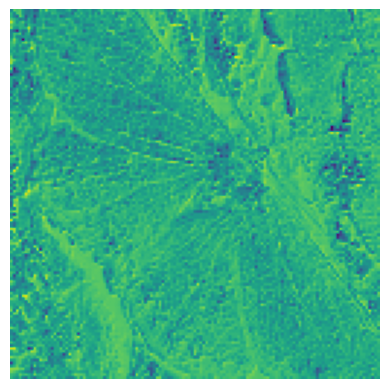


Output from module 1


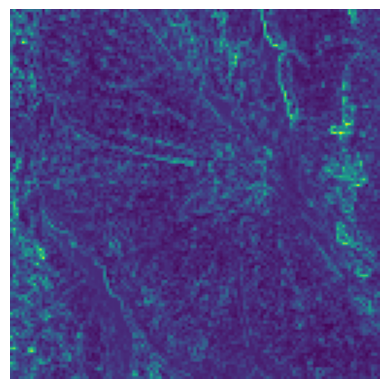


Output from module 2


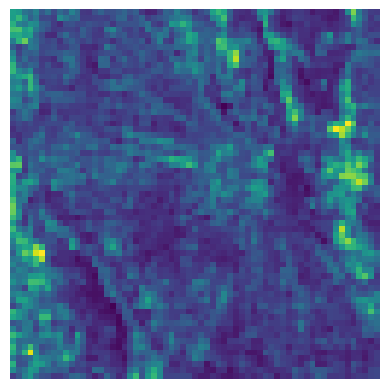


Output from module 3


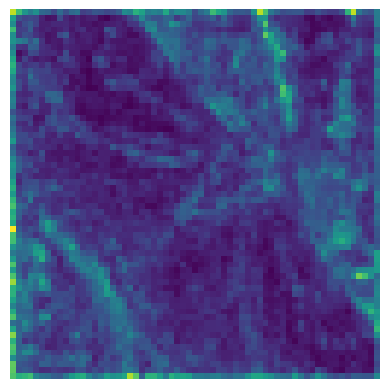


Output from module 4


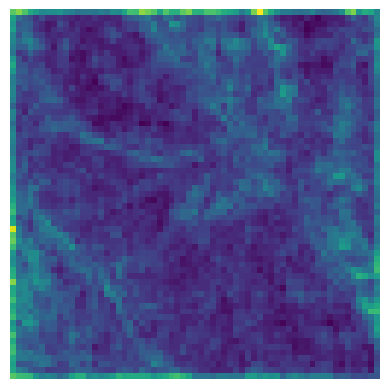


Output from module 5


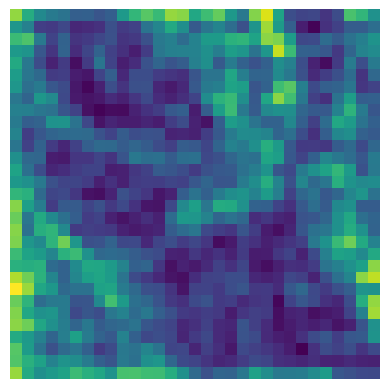


Output from module 6


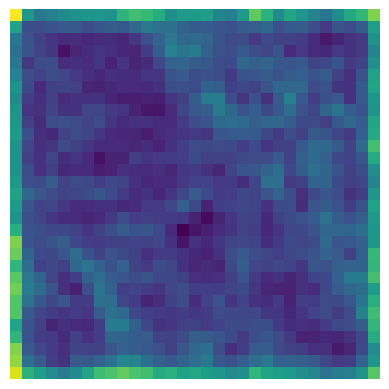


Output from module 7


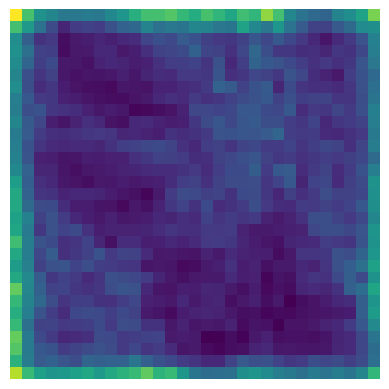


Output from module 8


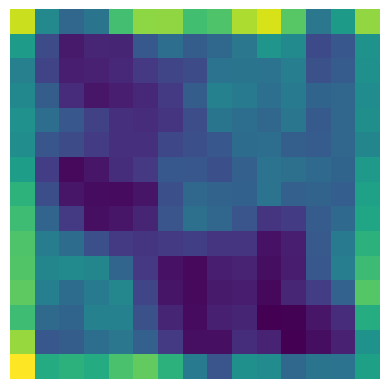


Output from module 9


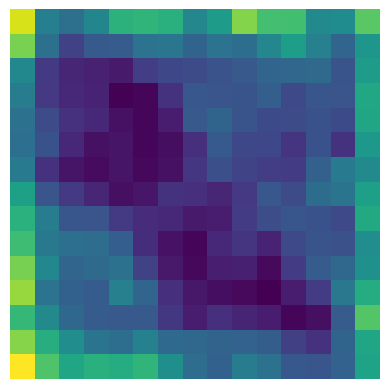


Output from module 10


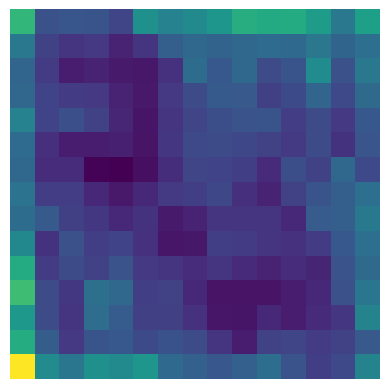


Output from module 11


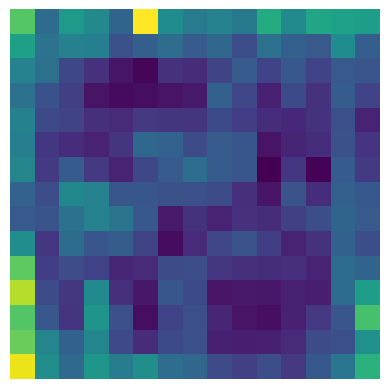


Output from module 12


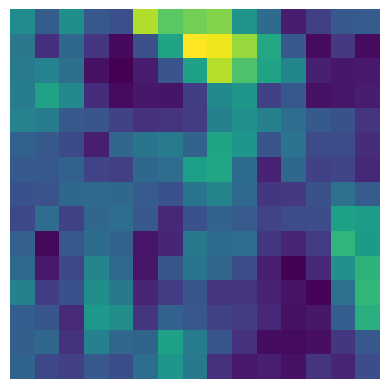

In [9]:
img = read_image('./data/Mini-Set/butterfly-image.jpg')
layer_visualizer(img, args)

Iteration 0


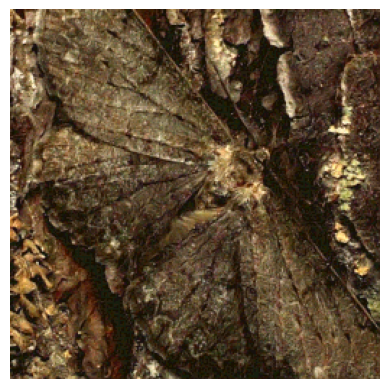

Iteration 100


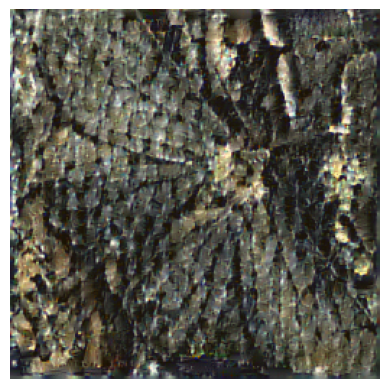

Iteration 200


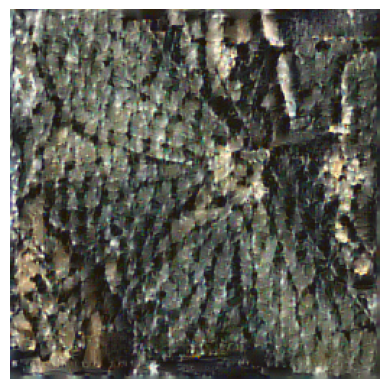

Iteration 249


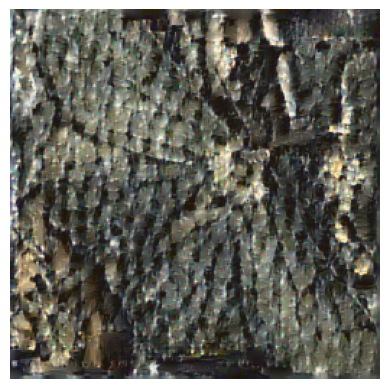




 Loss plots


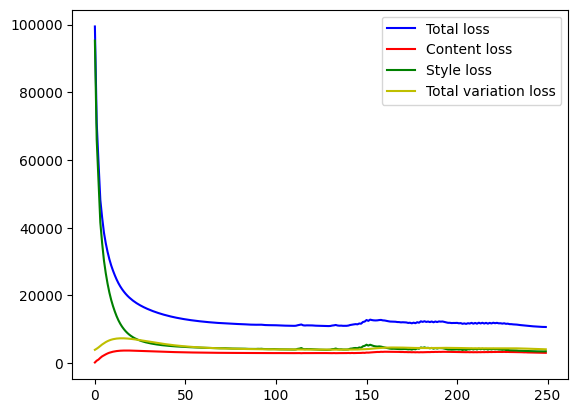

In [10]:
run_style_transfer_pipeline(args)